In [1]:
import torch
import torch.nn as nn
import os
from model import RobertaGAT
from dataset import CustomDataset
from torch_geometric.loader import DataLoader

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
# 加载数据集
from datasets import load_dataset, DatasetDict

dataset_train = load_dataset('csv', data_files='data/train.csv', encoding='utf-8')
dataset_test = load_dataset('csv', data_files='data/test.csv', encoding='utf=8')
dataset_valid = load_dataset('csv', data_files='data/validation.csv', encoding='utf-8')
dataset = DatasetDict({'train': dataset_train, 'test': dataset_test, 'validation': dataset_valid})
# dataset = DatasetDict({'test': dataset_test})

In [3]:
# 分词
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def encode_batch(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=224, return_tensors="pt")

dataset = {split: dataset[split].map(encode_batch, batched=True) for split in dataset.keys()}
dataset['test']['train'] = dataset['test']['train'].remove_columns('text')
dataset['train']['train'] = dataset['train']['train'].remove_columns('text')
dataset['validation']['train'] = dataset['validation']['train'].remove_columns('text')

Map:   0%|          | 0/16217 [00:00<?, ? examples/s]

Map:   0%|          | 0/17102 [00:00<?, ? examples/s]

In [4]:
# 获取边关系
from utils import get_sentence_rel
# 训练集边关系
train_sen_rel = get_sentence_rel(path='data/train.csv')
# 测试集合边关系
test_sen_rel = get_sentence_rel(path='data/test.csv')
# 验证集合边关系
valid_sen_rel = get_sentence_rel(path='data/validation.csv')

In [5]:
import copy
from utils import spilt_node

train_data = spilt_node(dataset['train']['train'])
test_data = spilt_node(dataset['test']['train'])
train_dataset = CustomDataset(train_data, train_sen_rel, 25)
test_dataset = CustomDataset(test_data, test_sen_rel, 25)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaGAT("roberta-base", num_classes=5)
model.roberta_first_half.to('cuda:0')
model.roberta_second_half.to('cuda:1')

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss()
num_epochs = 50

# writer = SummaryWriter('log/robert-gat')

In [7]:
# from sklearn.metrics import accuracy_score, recall_score, f1_score
# 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model1 = RobertaGAT("roberta-base", num_classes=5)
# model2 = RobertaGAT("roberta-base", num_classes=5)
# model1.to("cuda:0")
# model2.to("cuda:1")
# optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
# optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
# 
# criterion = nn.CrossEntropyLoss()
# num_epochs = 50
# 
# # writer = SummaryWriter('log/robert-gat')
# 
# for epoch in range(num_epochs):
#     model1.train()
#     model2.train()
#     total_loss1 = 0
#     total_loss2 = 0 
#     for batch in train_loader:
#         print(type(batch))
#         print(len(batch))
#         graph1, graph2 = batch.batch
#         if graph1['y'].size()[0] <= 30:
#             input_ids = graph1['x'].to('cuda:0')
#             attention_mask = graph1['mask'].to('cuda:0')
#             edge_index = graph1['edge_index'].to('cuda:0')
#             labels = graph1['y'].to('cuda:0')
#             optimizer1.zero_grad()
#             output, weight1 = model1(input_ids, attention_mask, edge_index)
#             loss = criterion(output[1:].to('cuda:0'), labels[1:])
#             loss.backward()
#             optimizer1.step()
#             total_loss1 += loss.item()
#         if graph2['y'].size()[0] <= 30:
#             input_ids = graph2['x'].to('cuda:1')
#             attention_mask = graph2['mask'].to('cuda:1')
#             edge_index = graph2['edge_index'].to('cuda:1')
#             labels = graph2['y'].to('cuda:1')
#             optimizer2.zero_grad()
#             output, weight2 = model2(input_ids, attention_mask, edge_index)
#             loss2 = criterion(output[1:].to('cuda:1'), labels[1:])
#             loss2.backward()
#             optimizer2.step()
#             total_loss2 += loss2.item()
# 
#         
#         
#     avg_loss_model1 = total_loss1 / len(train_loader)
#     avg_loss_model2 = total_loss2 / len(train_loader)
#     # 测试部分
#     model1.eval()  # 或者 model2.eval()，取决于您选择哪个模型进行测试
#     total_test_loss = 0
#     all_labels = []
#     all_preds = []
#     with torch.no_grad():  # 确保不计算梯度
#         for batch in test_loader:  # 测试数据加载
#             input_ids = batch['x'].to('cuda:0')  # 或 'cuda:1'
#             attention_mask = batch['mask'].to('cuda:0')  # 或 'cuda:1'
#             edge_index = batch['edge_index'].to('cuda:0')  # 或 'cuda:1'
#             labels = batch['y'].to('cuda:0')  # 或 'cuda:1'
# 
#             output, _ = model1(input_ids, attention_mask, edge_index)  # 或 model2
#             loss = criterion(output[1:].to('cuda:0'), labels[1:])  # 或 'cuda:1'
#             total_test_loss += loss.item()
# 
#             preds = output.argmax(dim=1)
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(preds.cpu().numpy())
# 
#     avg_test_loss = total_test_loss / len(test_loader)
#     accuracy = accuracy_score(all_labels, all_preds)
#     recall = recall_score(all_labels, all_preds, average='macro')
#     f1 = f1_score(all_labels, all_preds, average='macro')
# 
# 
#     print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss_model1}, Testing Loss: {avg_test_loss}, Accuracy: {accuracy}, Recall: {recall}, F1 Score: {f1}")

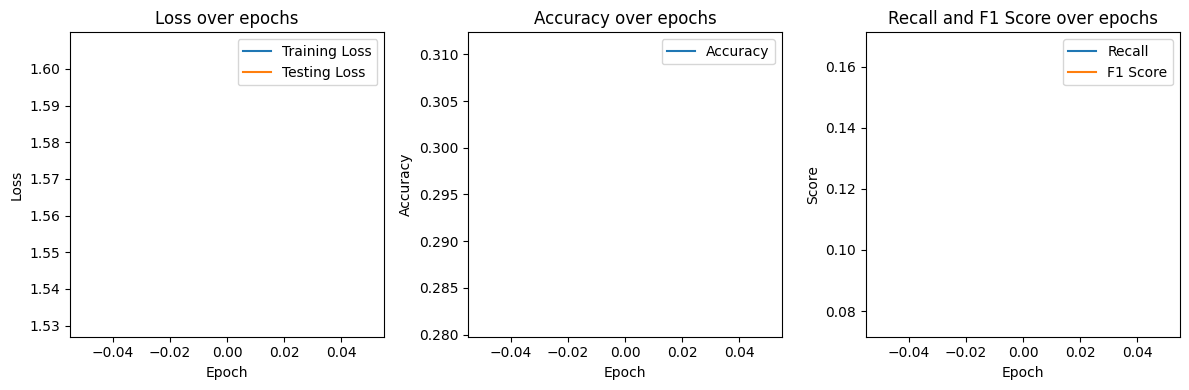

Epoch 1/50, Training Loss: 1.6061917311465579, Testing Loss: 1.530747434940744, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


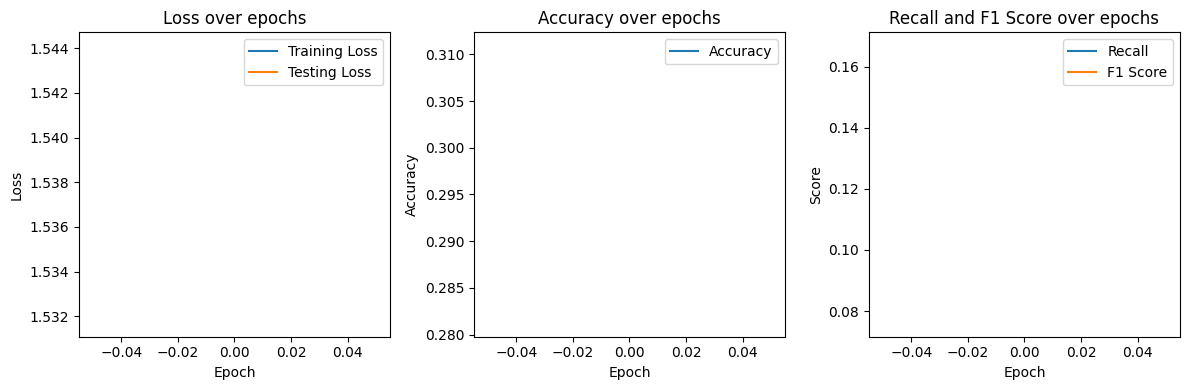

Epoch 2/50, Training Loss: 1.5317068728925956, Testing Loss: 1.544089144341489, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


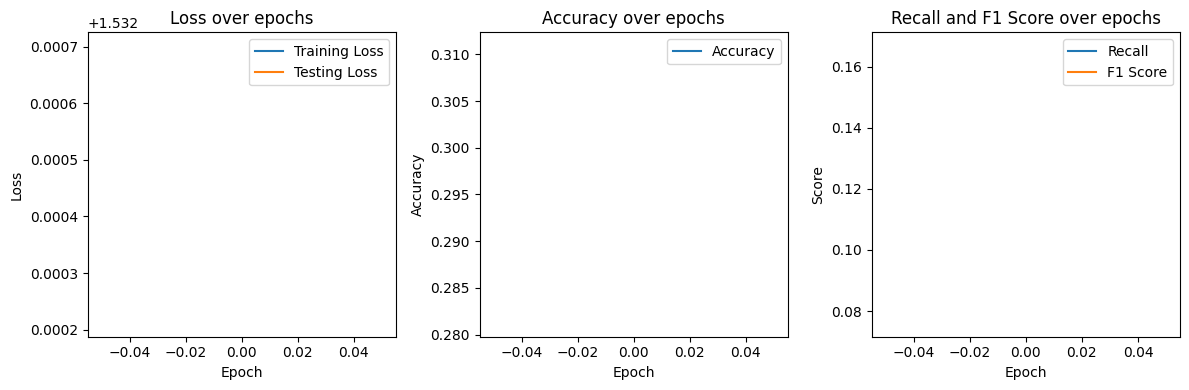

Epoch 3/50, Training Loss: 1.5322119603869062, Testing Loss: 1.532700595449894, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


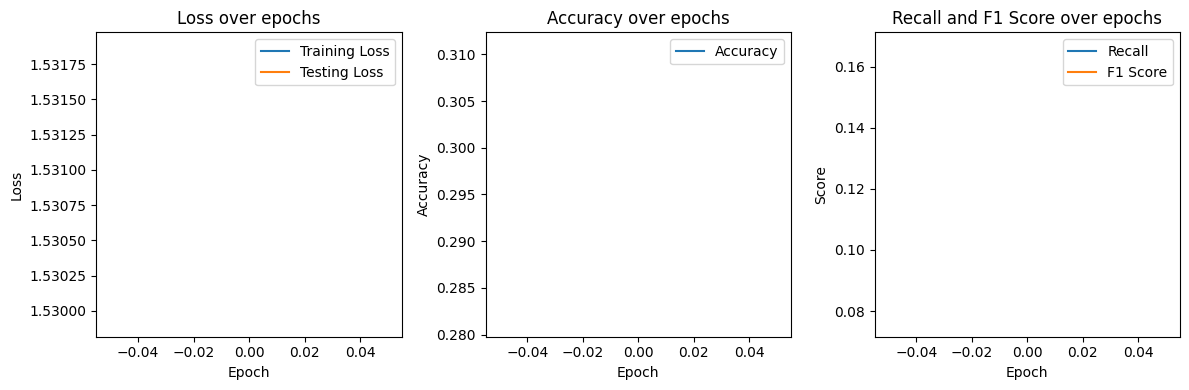

Epoch 4/50, Training Loss: 1.53187776971187, Testing Loss: 1.529914942700812, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


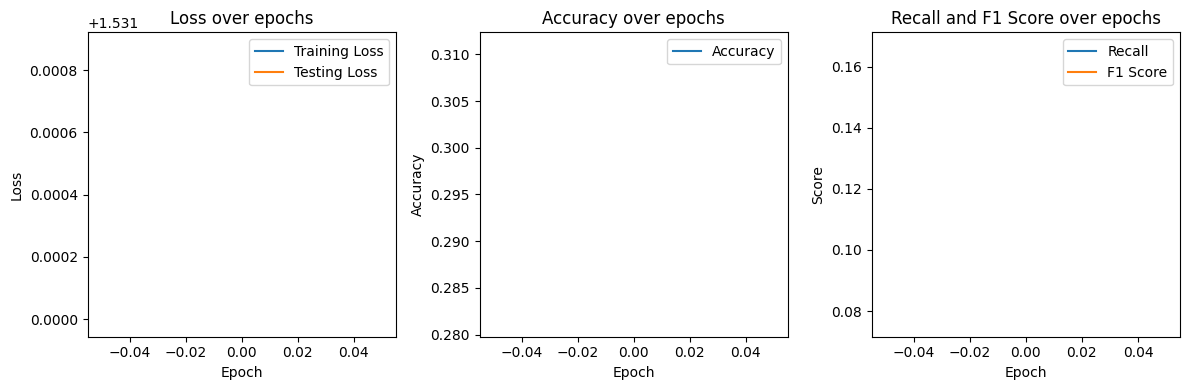

Epoch 5/50, Training Loss: 1.530987662966974, Testing Loss: 1.5318766177968777, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


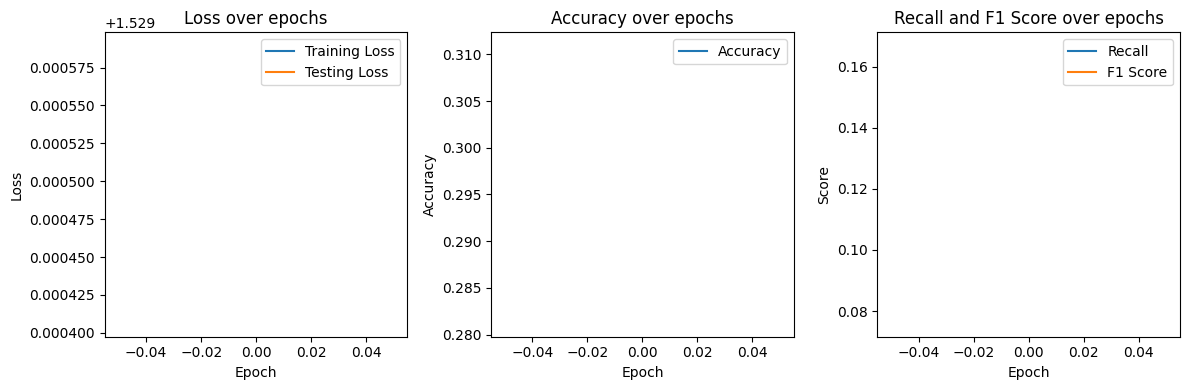

Epoch 6/50, Training Loss: 1.5295890676489783, Testing Loss: 1.5294066099410362, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938


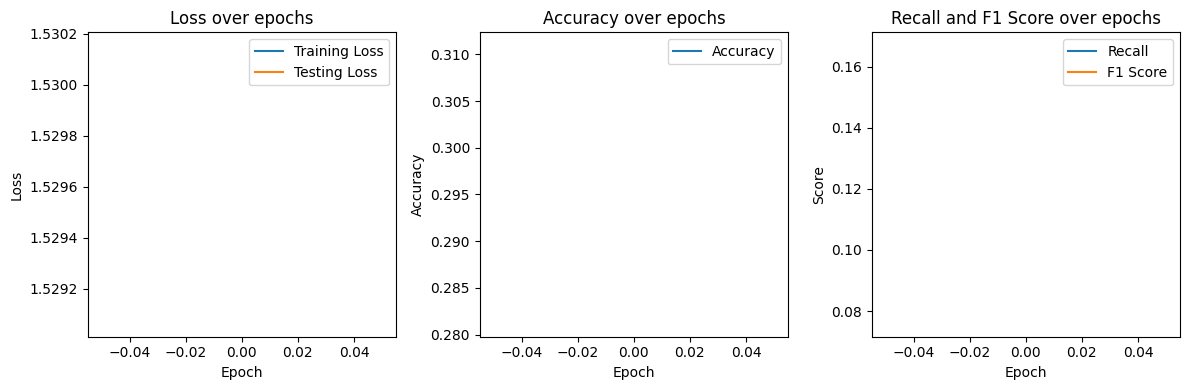

Epoch 7/50, Training Loss: 1.5301520189009101, Testing Loss: 1.5290661309627775, Accuracy: 0.2960650406504065, Recall: 0.16666666666666666, F1 Score: 0.07614459443635938



KeyboardInterrupt



In [8]:
from sklearn.metrics import accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt

for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    accuracies = []
    recalls = []
    f1_scores = []
    model.train()
    total_loss = 0
    for batch in train_loader:
        s = 0
        if len(batch) != 4:
            continue
        for i in range(len(batch)):
            s += batch[i]['y'].size()[0]
        if s > 100:
            continue
        #合并四个图的节点特征、标签等
        input_ids = torch.cat((batch[0]['x'], batch[1]['x'], batch[2]['x'], batch[3]['x']), dim=0).to('cuda:0')
        attention_mask = torch.cat((batch[0]['mask'], batch[1]['mask'], batch[2]['mask'], batch[3]['mask']), dim=0).to('cuda:0')
        labels = torch.cat((batch[0]['y'], batch[1]['y'], batch[2]['y'], batch[3]['y']), dim=0).to('cuda:1')
        num_nodes_graph1 = batch[0]['x'].size(0)
        num_nodes_graph2 = batch[1]['x'].size(0) + num_nodes_graph1
        num_nodes_graph3 = batch[2]['x'].size(0) + num_nodes_graph2
        edge_index_1 = batch[0]['edge_index'].to('cuda:1')
        edge_index_2 = batch[1]['edge_index'] + num_nodes_graph1  # 加上偏移
        edge_index_3 = batch[2]['edge_index'] + num_nodes_graph2
        edge_index_4 = batch[3]['edge_index'] + num_nodes_graph3
        edge_index = torch.cat((edge_index_1, edge_index_2.to('cuda:1'), edge_index_3.to('cuda:1'), edge_index_4.to('cuda:1')), dim=1)
        optimizer.zero_grad()
        output, weight1 = model(input_ids, attention_mask, edge_index)
        output_without_num = torch.cat((output[1:num_nodes_graph1], output[num_nodes_graph1+1:num_nodes_graph2], output[num_nodes_graph2+1:num_nodes_graph3], output[num_nodes_graph3+1:]))
        label_without_num = torch.cat((labels[1:num_nodes_graph1], labels[num_nodes_graph1+1:num_nodes_graph2], labels[num_nodes_graph2+1:num_nodes_graph3], labels[num_nodes_graph3+1:]))
        loss = criterion(output_without_num.to("cuda:1"), label_without_num)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(train_loader)

    model.eval()  # 测试
    total_test_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():  
        for batch in test_loader:
            s = 0
            if len(batch) != 4:
                continue
            for i in range(len(batch)):
                s += batch[i]['y'].size()[0]
            if s > 100:
                continue
            input_ids = torch.cat((batch[0]['x'], batch[1]['x'], batch[2]['x'], batch[3]['x']), dim=0).to('cuda:0')
            attention_mask = torch.cat((batch[0]['mask'], batch[1]['mask'], batch[2]['mask'], batch[3]['mask']), dim=0).to('cuda:0')
            labels = torch.cat((batch[0]['y'], batch[1]['y'], batch[2]['y'], batch[3]['y']), dim=0).to('cuda:1')
            num_nodes_graph1 = batch[0]['x'].size(0)
            num_nodes_graph2 = batch[1]['x'].size(0) + num_nodes_graph1
            num_nodes_graph3 = batch[2]['x'].size(0) + num_nodes_graph2
            edge_index_1 = batch[0]['edge_index'].to('cuda:1')
            edge_index_2 = batch[1]['edge_index'] + num_nodes_graph1  # 加上偏移
            edge_index_3 = batch[2]['edge_index'] + num_nodes_graph2
            edge_index_4 = batch[3]['edge_index'] + num_nodes_graph3
            edge_index = torch.cat((edge_index_1, edge_index_2.to('cuda:1'), edge_index_3.to('cuda:1'), edge_index_4.to('cuda:1')), dim=1)
            output, weight1 = model(input_ids, attention_mask, edge_index)
            output_without_num = torch.cat((output[1:num_nodes_graph1], output[num_nodes_graph1+1:num_nodes_graph2], output[num_nodes_graph2+1:num_nodes_graph3], output[num_nodes_graph3+1:]))
            label_without_num = torch.cat((labels[1:num_nodes_graph1], labels[num_nodes_graph1+1:num_nodes_graph2], labels[num_nodes_graph2+1:num_nodes_graph3], labels[num_nodes_graph3+1:]))
            loss = criterion(output_without_num.to("cuda:1"), label_without_num)
            total_test_loss += loss.item()

            # 假设output是模型预测的原始分数或者概率
            # 转换为最终类别预测（例如，使用argmax）
            preds = output.argmax(dim=1)

            # 收集所有的标签和预测结果
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            torch.cuda.empty_cache()
    avg_test_loss = total_test_loss / len(test_loader)

    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    # 在训练循环结束后
    train_losses.append(avg_loss)
    test_losses.append(avg_test_loss)
    accuracies.append(accuracy)
    recalls.append(recall)
    f1_scores.append(f1)
    # 训练循环结束后
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Testing Loss')
    plt.xlabel('Epoch') 
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 3, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')

    plt.subplot(1, 3, 3)
    plt.plot(recalls, label='Recall')
    plt.plot(f1_scores, label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Recall and F1 Score over epochs')

    plt.tight_layout()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_loss}, Testing Loss: {avg_test_loss}, Accuracy: {accuracy}, Recall: {recall}, F1 Score: {f1}")
    
    
plt.tight_layout()
plt.savefig('training_performance.png')
plt.show()

In [ ]:
import pandas as pd

pd.read_csv("data/train.csv", )